# HMM PoS Tagg

Authors: *Andrea Jaunarena*, *Markel Ferro*, *Juliana Planas* and *Lukas Arana*

This notebook presents the results and error analysis of the Hidden Markov Model (HMM) Part-of-Speech (PoS) tagger implemented in our_HMM.py. The purpose is to evaluate the accuracy and generalization capability of the HMM tagger through a series of in-domain and out-of-domain experiments.  

Two different types of experiments can be found in this notebook:
1. In-Domain Experiments:
- The model is trained and tested using datasets from Universal Dependencies.
- The same dataset, split in train and test, will be used to evaluate the resulting model.
- The evaluation of the tagger's performance was done using accuracy and other evaluation metrics.

2. Out-of-Domain Experiments:
- The trained model will be evaluated on test data from previously unseen domains to assess its ability to generalize beyond the training data.

## Datasets


- Dataset: en_ewt-ud

The UD_English-EWT (English Web Treebank) dataset is part of the Universal Dependencies (UD) project. This dataset consists of texts sourced from web-based content, including blog posts, emails, reviews, and question-answering forums. It is larger and more balanced in terms of data distribution.

- Dataset: en_gumreddit-ud

The UD_English-GUMReddit dataset is a part of the Universal Dependencies (UD) project and is derived from the Georgetown University Multilayer (GUM) corpus. It is smaller in size and focuses on Reddit posts, capturing informal and conversational English from online discussions. Annotation quality may be more challenging due to the informal nature of the data, with ambiguous or unconventional grammatical constructions.

## In-domain experiments

### Imports

In [3]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [1]:
!pip install conllu
!pip install pandas
!pip install evaluate
!pip install scikit-learn
!pip install colorama
!pip install matplotlib
!pip install --upgrade matplotlib ipython jupyter

  Using cached conllu-6.0.0-py3-none-any.whl.metadata (21 kB)
Using cached conllu-6.0.0-py3-none-any.whl (16 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.0-cp310-cp310-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-macosx_10_9_x86_64.whl (12.6 MB)
Using cached numpy-2.2.0-cp310-cp310-macosx_14_0_x86_64.whl (6.9 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0

In [2]:
from get_list_upos import parse_conllu, Lemma, Upos
import importlib
import our_HMM
importlib.reload(our_HMM)
from our_HMM import our_HMM, UNKNOWN_KEYWORD, START_TAG, END_TAG
import random
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('inline')

Matplotlib is building the font cache; this may take a moment.


### First Dataset: en_ewt-ud

Following the approach used in the in-domain experiments, we will utilize the same dataset, en_ewt-ud, for both training and testing the model.

In [ ]:
train_file_ewt = "data/en_ewt-ud-train.conllu"
test_file_ewt = "data/en_ewt-ud-test.conllu"

unk_threshold = 1
word_model = "form"
model = our_HMM(train_file_ewt, unk_threshold=unk_threshold, word_model=word_model)

In [ ]:
results, parsed_file, preds_tag, gold_tag = model.test(test_file_ewt)

/home/lufanta/Desktop/sintax/HMM_Andrea/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Analysis of the results

We will use two different approaches to analyze the results obtained by the model.
* We will check the most common mistakes created by the HMM. 
* We will analyze random sentences by hand, in order to check whether we are able to draw any conclusions.

##### Metrics

In [57]:
results

{'precision_micro': 0.8414931237721022,
 'precision_macro': 0.8499062333786642,
 'recall_micro': 0.8414931237721022,
 'recall_macro': 0.7224780639192916,
 'f1_micro': 0.8414931237721022,
 'f1_macro': 0.7582949852286345,
 'accuracy': 0.8414931237721022}

1. High Overall Performance: The accuracy of 84.15% indicates that the model correctly predicted the majority of tags in the test data.

2. Micro-Averaged Metrics: The precision_micro, recall_micro, and f1_micro values are all at 84.15%. This consistency shows that the model performs uniformly across all tags without bias toward more frequent tags.

3. Macro-Averaged Metrics: The precision_macro of 84.99% is slightly higher than the f1_macro of 75.83% and the recall_macro of 72.25%. This discrepancy indicates that while the model is good at assigning correct tags when it predicts them (precision), it struggles to identify all instances of certain tags (recall). This is likely due to imbalances or rarer tags in the dataset.

4. Challenges with Rare Tags: The lower recall_macro suggests that the model may not generalize well to less frequent or more challenging tags in the dataset.

5. Balanced Strengths: The high precision suggests that the model makes accurate predictions for the tags it identifies, while the slightly lower recall indicates room for improvement in identifying less common tags.


##### Most repeated failures

In [58]:
%matplotlib inline
from collections import Counter
import numpy as np
def plot_prediction_failures(failures_data):
    # Set seaborn style for better aesthetics
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Prepare data for plotting
    ground_truth_labels = [f"{gt}->{pred}" for (gt, pred), _ in failures_data]
    failure_frequencies = [freq for _, freq in failures_data]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(ground_truth_labels, failure_frequencies, 
                   color='#5A9BD5',  # Professional blue
                   edgecolor='#1F3864',  # Dark navy edge
                   alpha=0.8,
                   width=0.7)
    # Typography improvements
    plt.title('Prediction Failure Frequencies', 
              fontsize=18, 
              fontweight='bold', 
              color='#333333')
    plt.xlabel('Ground Truth → Prediction', 
               fontsize=14, 
               color='#555555')
    plt.ylabel('Failure Frequency', 
               fontsize=14, 
               color='#555555')
    
    # Rotate labels and adjust positioning
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add value labels with improved styling
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.0f}', 
                 ha='center', va='bottom', 
                 fontsize=10,
                 fontweight='bold',
                 color='#1F3864')
    
    # Adjust layout
    plt.tight_layout()
    plt.grid(False)
    return plt

# Professional appearance
plt.tight_layout()
plt.show()

def create_histogram(preds_tag, gold_tag, k_show = 25):
    mistake_pairs = [(preds_tag[i][j], gold_tag[i][j]) for i in range(len(preds_tag)) for j in range(len(preds_tag[i])) if preds_tag[i][j] != gold_tag[i][j]]
    count_mistakes = Counter(mistake_pairs)
    tuple_repeated = count_mistakes.most_common(k_show)
    plot_prediction_failures(tuple_repeated)
    return tuple_repeated

<Figure size 800x550 with 0 Axes>

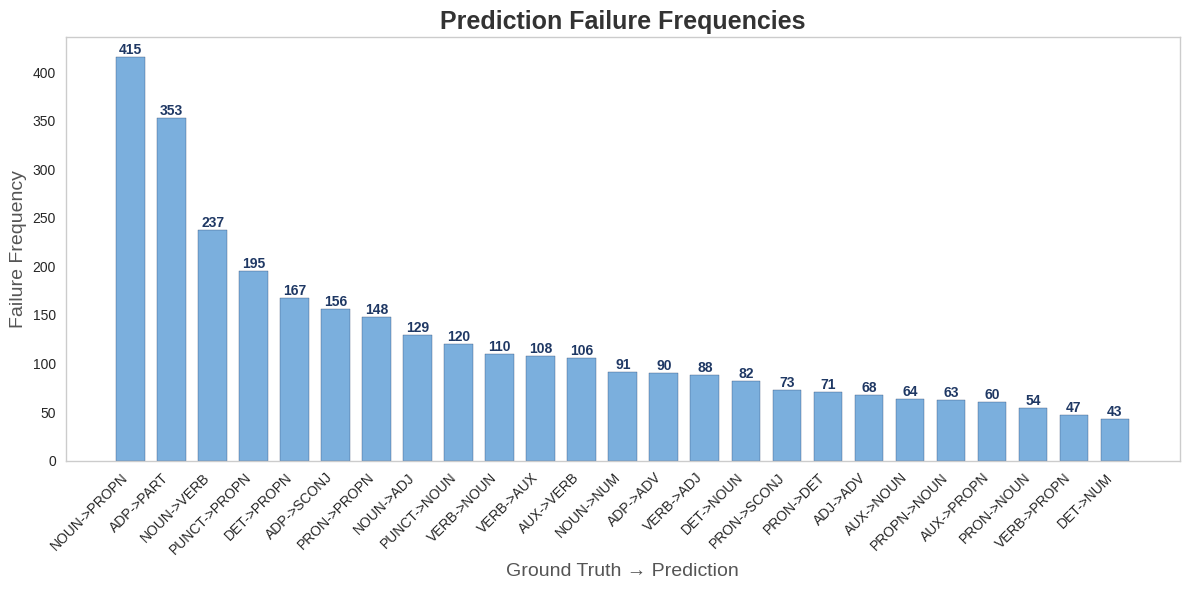

In [59]:
most_repeated_tuples = create_histogram(preds_tag, gold_tag)


- The most common error is misclassifying NOUN (common noun) as PROPN (proper noun). This suggests that the model struggles to distinguish between general nouns and proper nouns. This could be due to the use of lowercase in the data.

- Another frequent mistake involves ADP (adposition) being misclassified as PART (particle). This highlights the model's challenge in identifying subtle grammatical roles in phrases, as both categories can appear in similar contexts.

- The model frequently misclassifies various tags (e.g., PUNCT, DET, PRON) as PROPN, indicating that proper nouns are a frequent source of confusion. This could stem from a limited representation of proper nouns in the training data.

- Errors like PRON → SCONJ and ADP → SCONJ indicate difficulty in correctly tagging function words that can take on similar roles depending on the sentence structure.

- The model misclassifies NOUN → ADJ and DET → ADJ, showing confusion in distinguishing nouns and determiners that function as descriptors in certain contexts.

##### Human examination

In [63]:
def show_results(preds_tag, gold_tag, parsed_file, idxes = None, k = 10):
    if not idxes:
        idxes = random.sample(list(range(len(preds_tag))), k)
    for idx in idxes:
        print("-" * 10 + f" sentence: {idx} " + "-" * 10)
        colors = [Fore.RED if preds_tag[idx][i] != gold_tag[idx][i] else Fore.GREEN for i in range(len(preds_tag[idx]))]
        print(Fore.BLUE + "Predictions: " + ", ".join([colors[i] + f"{preds_tag[idx][i]}" for i in range(len(colors))]))
        print(Fore.BLUE + "Ground Truth: " + ", ".join([colors[i] + f"{gold_tag[idx][i]}" for i in range(len(colors))]))
        print(Fore.BLUE + "Sentence: " + " ".join([colors[i] + f"{parsed_file[i][0][0]}" for i in range(len(parsed_file[idx]))]))

show_results(preds_tag, gold_tag, parsed_file)

---------- sentence: 50 ----------
Predictions: PRON, VERB, PRON, VERB
Ground Truth: VERB, PRON, NOUN, PUNCT
Sentence: _ _ _ _
---------- sentence: 44 ----------
Predictions: PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON
Ground Truth: PRON, VERB, ADP, DET, NOUN, PART, VERB, CCONJ, DET, NOUN, VERB, ADP, DET, NOUN, ADP, NOUN, CCONJ, VERB, DET, NOUN, PRON, VERB, PUNCT, NOUN, VERB, PUNCT, AUX, PRON, VERB, ADP, PRON, ADP, NOUN, PUNCT, PUNCT
Sentence: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ __ _ _ _ _ _ _ _ _
---------- sentence: 40 ----------
Predictions: PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB
Ground Truth: DET, ADJ, NOUN, VERB, ADV, PUNCT, PRON, VERB, ADV, SCONJ, PRON, AUX, VERB, ADP, PUNCT, CCONJ, DET, NOUN, AUX, DET, NOUN, PU

- The predictions consistently begin with PRON followed by VERB, regardless of the actual sentence structure or ground truth. This suggests the model might be heavily biased toward predicting these tags at the start of sentences, possibly due to a strong prior belief in this sequence from the training data.

- The model seems to overuse PRON and VERB tags throughout the predictions, which might indicate a lack of diversity in its tagging approach or insufficient training data for other tags.

- Tags like DET, ADJ, SCONJ, and AUX, which are present in the ground truth, are often missing or replaced with PRON or VERB in the predictions. This shows the model struggles to differentiate and correctly identify these functional and auxiliary tags.

- The prediction sequences display a lack of variability, with the same tags (primarily PRON and VERB) repeated for most tokens. This indicates the model might not be effectively utilizing context or word-specific information during prediction.


### Second Dataset: en_gumreddit-ud

In [3]:
train_file_reddit = "data/en_gumreddit-ud-train.conllu"
test_file_reddit = "data/en_gumreddit-ud-test.conllu"

unk_threshold = 1
word_model = "form"
model_reddit = our_HMM(train_file_reddit, unk_threshold=unk_threshold, word_model=word_model)

In [4]:
results_reddit, parsed_file_reddit, preds_tag_reddit, gold_tag_reddit = model_reddit.test(test_file_reddit)

AttributeError: 'float' object has no attribute 'size'

#### Analysis of the results

##### Metrics

In [ ]:
results_reddit

{'precision_micro': 0.14534883720930233,
 'precision_macro': 0.06999655046530047,
 'recall_micro': 0.14534883720930233,
 'recall_macro': 0.11661875909037644,
 'f1_micro': 0.14534883720930233,
 'f1_macro': 0.0788473316315183,
 'accuracy': 0.14534883720930233}

1. Low Overall Performance: The accuracy is only 14.53%, indicating that the model struggles to generalize to this dataset.

2. Micro-Averaged Metrics: The precision_micro, recall_micro, and f1_micro are consistent at 14.53%, reflecting that the model performs equally poorly across all predictions, regardless of the specific tags.

3. Macro-Averaged Metrics: The precision_macro (6.99%) and recall_macro (11.66%) are notably lower than their micro counterparts. This discrepancy highlights that the model performs worse on less frequent tags, failing to generalize across the tag set.

4. F1 Scores: The f1_macro score of 7.88% indicates that the model struggles to balance precision and recall for rare tags, likely leading to a poor ability to capture the diversity of the dataset.

##### Difficult tuples

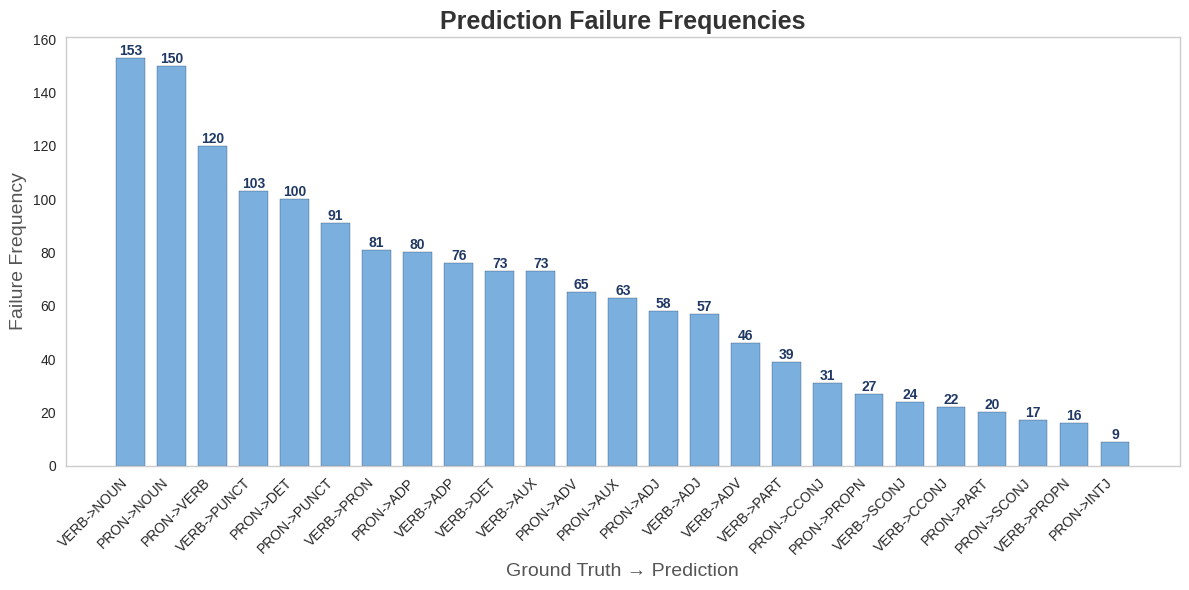

In [ ]:
most_repeated_tuples = create_histogram(preds_tag_reddit, gold_tag_reddit)

- The most common error involves verbs being predicted as nouns. This may reflect the informal nature of the GUMReddit dataset, where verbs and nouns are often used interchangeably or creatively.

- Pronouns are frequently misclassified as nouns or verbs. This could be due to the flexible usage of pronouns in informal language, where context heavily influences their role.

- Errors like VERB → PUNCT and PRON → PUNCT suggest difficulty in distinguishing between syntactic and semantic elements in noisy text. This is common in datasets like Reddit, where punctuation may be omitted, overused, or used non-standardly.

- Misclassifications such as PRON → DET and VERB → ADP indicate difficulty distinguishing determiners, adpositions, and pronouns.

- Pronouns are highly versatile in informal contexts, leading to errors such as PRON → AUX, PRON → ADP, and even PRON → ADV.

- Errors like VERB → AUX and VERB → PART suggest a challenge in identifying auxiliary verbs and particles, likely due to their subtle grammatical roles and reliance on sentence context for proper classification.

##### Human examination

In [ ]:
show_results(preds_tag_reddit, gold_tag_reddit, parsed_file_reddit)

---------- sentence: 3 ----------
Predictions: PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON
Ground Truth: PRON, AUX, ADV, VERB, ADP, DET, NOUN, VERB, ADP, NOUN, PRON, PRON, VERB, AUX, NOUN, NOUN, SCONJ, DET, NOUN, VERB, DET, NOUN, PRON, VERB, CCONJ, VERB, PRON, PART, VERB, VERB, ADV, ADJ, PUNCT
Sentence: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ __ _ _ _ _ _ _
---------- sentence: 18 ----------
Predictions: PRON, VERB, PRON
Ground Truth: NUM, NOUN, ADV
Sentence: _ _ _
---------- sentence: 22 ----------
Predictions: PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON
Ground Truth: PART, PART, VERB, X, PRON, NOUN, CCONJ, PUNCT, DET, NOUN, PUNCT
Sentence: _ _ _ _ _ _ _ _ _ _ _
---------- sentence: 65 ----------
Predictions: PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB, PRON, VERB

- 

## Out-domain experiments

In [ ]:
unk_threshold = 1
word_model = "form"

model_train_ewt_test_reddit = our_HMM(train_file_ewt, unk_threshold=unk_threshold, word_model=word_model)
results_on_reddit, parsed_file_on_reddit, preds_tag_on_reddit, gold_tag_on_reddit = model_train_ewt_test_reddit.test(test_file_reddit)

model_train_reddit_test_ewt = our_HMM(train_file_reddit, unk_threshold=unk_threshold, word_model=word_model)
results_on_ewt, parsed_file_on_ewt, preds_tag_on_ewt, gold_tag_on_ewt = model_train_reddit_test_ewt.test(test_file_ewt)


/home/lufanta/Desktop/sintax/HMM_Andrea/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lufanta/Desktop/sintax/HMM_Andrea/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Analysis of the results

#### Metrics

In [ ]:
results_on_reddit

{'precision_micro': 0.0824524312896406,
 'precision_macro': 0.004672057502246182,
 'recall_micro': 0.0824524312896406,
 'recall_macro': 0.05555555555555555,
 'f1_micro': 0.0824524312896406,
 'f1_macro': 0.008619260732637163,
 'accuracy': 0.0824524312896406}

In [ ]:
results_on_ewt

{'precision_micro': 0.09222003929273084,
 'precision_macro': 0.01538713260417918,
 'recall_micro': 0.09222003929273084,
 'recall_macro': 0.06269556944550671,
 'f1_micro': 0.09222003929273084,
 'f1_macro': 0.024480254769700165,
 'accuracy': 0.09222003929273084}

BALBALBLASLD

#### Difficult tuples

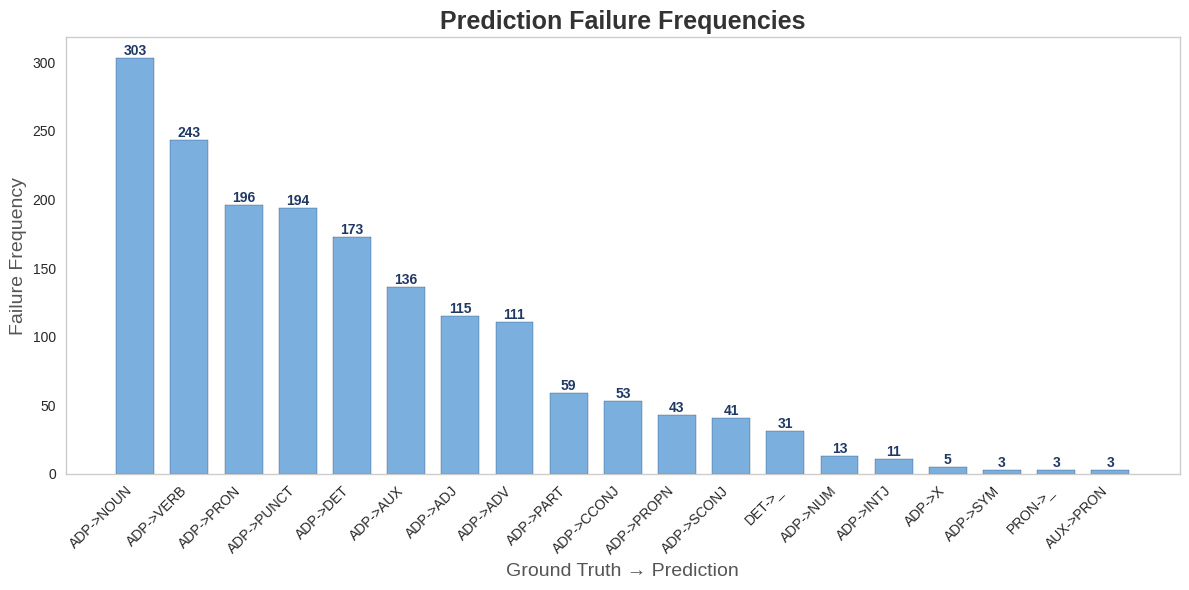

In [ ]:
most_repeated_tuples_on_reddit = create_histogram(preds_tag_on_reddit, gold_tag_on_reddit)


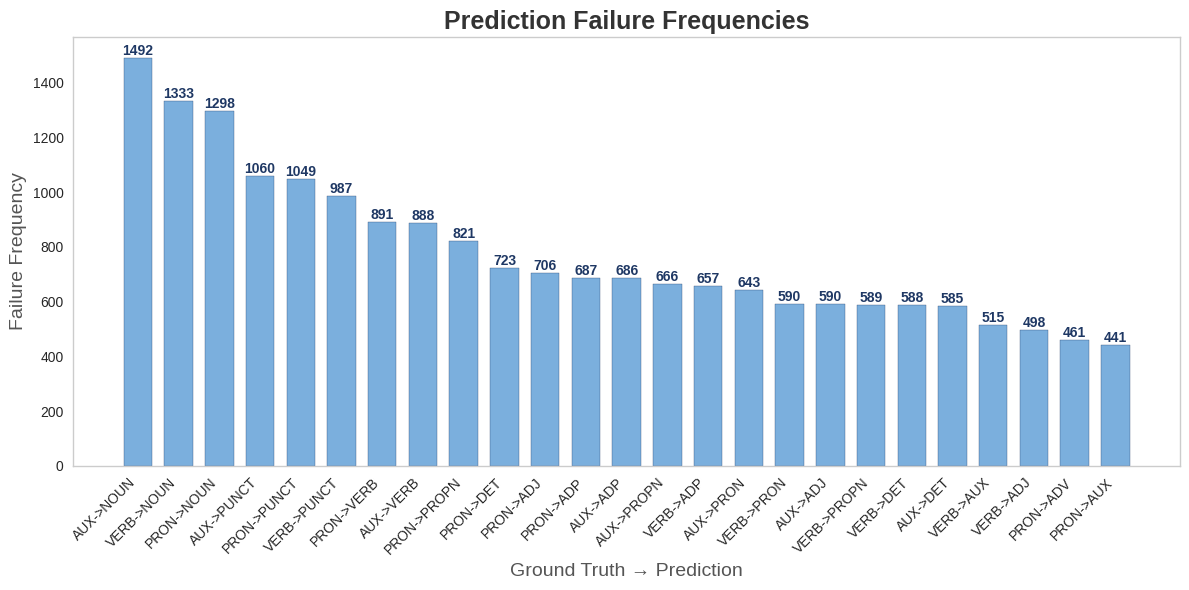

In [ ]:
most_repeated_tuples_on_ewt = create_histogram(preds_tag_on_ewt, gold_tag_on_ewt)


ASDASDASD

#### Human examination

In [ ]:
show_results(preds_tag_on_reddit, gold_tag_on_reddit, parsed_file_on_reddit)

---------- sentence: 6 ----------
Predictions: ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP
Ground Truth: ADV, PRON, NOUN, CCONJ, NOUN, VERB, PRON, PUNCT
Sentence: _ _ _ _ _ _ _ _
---------- sentence: 70 ----------
Predictions: ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP
Ground Truth: PROPN, AUX, DET, ADJ, NOUN, ADV, VERB, PUNCT
Sentence: _ _ _ _ _ _ _ _
---------- sentence: 13 ----------
Predictions: ADP, ADP, ADP, ADP
Ground Truth: PRON, AUX, PART, VERB
Sentence: _ _ _ _
---------- sentence: 45 ----------
Predictions: ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP
Ground Truth: CCONJ, DET, ADJ, NOUN, VERB, PRON, ADJ, NOUN, PUNCT
Sentence: _ _ _ _ _ _ _ _ _
---------- sentence: 83 ----------
Predictions: ADP, ADP, ADP, ADP
Ground Truth: CCONJ, DET, NOUN, PUNCT
Sentence: _ _ _ _
---------- sentence: 84 ----------
Predictions: PRON, AUX, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, ADP, 

In [ ]:
show_results(preds_tag_on_ewt, gold_tag_on_ewt, parsed_file_on_ewt)

---------- sentence: 1729 ----------
Predictions: PRON, AUX, VERB
Ground Truth: PART, ADJ, PUNCT
Sentence: What What [
---------- sentence: 905 ----------
Predictions: PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB
Ground Truth: NOUN, NOUN, PROPN, AUX, VERB, DET, NOUN, ADP, DET, PROPN, PART, VERB, PRON, PART, VERB, PRON, NOUN, AUX, VERB, ADP, PUNCT
Sentence: What What [ ( This Google Does They Is I'm I John Click He One On Compare You This Let I'm
---------- sentence: 2037 ----------
Predictions: PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON, AUX, VERB, PRON
Ground Truth: PRON, AUX, AUX, VERB, ADV, SCONJ, PRON, AUX, DET, ADJ, NOUN, CCONJ, VERB, DET, ADJ, CCONJ, ADJ, NOUN, PUNCT
Sentence: What What [ ( This Google Does They Is I'm I John Click He One On Compare You This
---------- sentence: 314 ----------
Predictions: PRON, AUX, VERB
Ground Truth: INTJ, PROPN, PUNCT
Sentenc

ASDASDASDASD

## Conclusions

ASDFASDFASDF